## 1. Linear Regression

In [7]:
from pandas import read_csv
train=read_csv("../데이터/고객소득수준예측.csv")

### 전처리 1. 의미상 Nan 값 제거

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      20000 non-null  object
 1   Age                     20000 non-null  int64 
 2   Gender                  20000 non-null  object
 3   Education_Status        20000 non-null  object
 4   Employment_Status       20000 non-null  object
 5   Working_Week (Yearly)   20000 non-null  int64 
 6   Industry_Status         20000 non-null  object
 7   Occupation_Status       20000 non-null  object
 8   Race                    20000 non-null  object
 9   Hispanic_Origin         20000 non-null  object
 10  Martial_Status          20000 non-null  object
 11  Household_Status        20000 non-null  object
 12  Household_Summary       20000 non-null  object
 13  Citizenship             20000 non-null  object
 14  Birth_Country           20000 non-null  object
 15  Bi

In [9]:
def make_nan(x:str):
    if not isinstance(x,str):
        return x
    if x.strip() in ["Unknown","Do not know","NA"]:
        return None
    else:
        return x

train=train.map(make_nan)
use_df=train.dropna(axis=0)

### 전처리 2. 범주형 데이터의 분류 및 처리

In [10]:
from sklearn import preprocessing as pre
education_levels = [
    'Children',
    'Kindergarten',
    'Elementary (1-4)',
    'Elementary (5-6)',
    'Middle (7-8)',
    'High Freshman',
    'High Sophomore',
    'High Junior',
    'High Senior',
    'High graduate',
    'Associates degree (Vocational)',
    'Associates degree (Academic)',
    'College',
    'Bachelors degree',
    'Masters degree',
    'Professional degree',
    'Doctorate degree']
income_levels=[
    'Under Median', 'Over Median'
]
Ordinary_=pre.OrdinalEncoder(categories=[education_levels,income_levels],handle_unknown="use_encoded_value",unknown_value=-1)

#### Oridnary
- 1. Education_Status
- 2. Income_Status

1. Children (유아기)
2. Kindergarten (유치원)
3. Elementary (1-4) (초등학교 1-4학년)
4. Elementary (5-6) (초등학교 5-6학년)
5. Middle (7-8) (중학교 7-8학년)
6. High Freshman (고등학교 1학년)
7. High Sophomore (고등학교 2학년)
8. High Junior (고등학교 3학년)
9. High Senior (고등학교 4학년)
10. High graduate (고등학교 졸업)
11. Associates degree (Vocational) (전문대학 학위, 직업 기술)
12. Associates degree (Academic) (전문대학 학위, 학문적)
13. College (대학, 일반적으로 학사 과정 시작 전)
14. Bachelors degree (학사 학위)
15. Masters degree (석사 학위)
16. Professional degree (전문 학위, 예: 법학, 의학 등)
17. Doctorate degree (박사 학위)

In [11]:
Ordinary_.fit_transform(use_df[["Education_Status","Income_Status"]])

array([[10.,  0.],
       [ 9.,  0.],
       [ 9.,  0.],
       ...,
       [ 9.,  0.],
       [12.,  0.],
       [ 9.,  0.]])

In [12]:
test_encoder=use_df[["Education_Status","Income_Status"]].values[:3]
print("Encoder_before \n",test_encoder)
print("-"*50)
test_encoder_result=Ordinary_.fit_transform(test_encoder)

print("Encoder_result \n",test_encoder_result)

Encoder_before 
 [['Associates degree (Vocational)' 'Under Median']
 ['High graduate' 'Under Median']
 ['High graduate' 'Under Median']]
--------------------------------------------------
Encoder_result 
 [[10.  0.]
 [ 9.  0.]
 [ 9.  0.]]


In [13]:
ordi_cols=["Education_Status","Income_Status"]
cate_cols=use_df.select_dtypes("object").columns.difference(["ID"]+ordi_cols)

In [14]:
value_list=[use_df[col].unique() for col in cate_cols]
Onehot_=pre.OneHotEncoder(categories=value_list,handle_unknown="ignore",sparse_output=False,drop='first')

In [15]:
Onehot_.fit_transform(use_df[cate_cols]).shape

(10319, 225)

In [16]:
print("처리한 이산형 특성 개수",len(cate_cols))
print("메트릭스 크기 :",Onehot_.fit_transform(use_df[cate_cols].values).shape)

처리한 이산형 특성 개수 14
메트릭스 크기 : (10319, 225)


### 단일 특성 학습

In [17]:
feature=["Age"]
label=["Income"]

x_bar=use_df.Age.mean()
print("x_bar :",x_bar)
w_top=use_df.Income*(use_df.Age-x_bar)
w_bottom=use_df.Age**2-x_bar**2
w=w_top.sum()/w_bottom.sum()

b=(use_df.Income-w*use_df.Age).mean()

print("w* :",w)
print("b* :",b)

x_bar : 37.072100009690864
w* : 5.331153498672447
b* : 529.3386202677925


In [18]:
from sklearn import linear_model as lin
linear_=lin.LinearRegression()
linear_.fit(X=use_df.Age.values.reshape(-1,1),y=use_df.Income.values)

LinearRegression()

In [19]:
print("w :",linear_.coef_)
print("b :",linear_.intercept_)

w : [5.3311535]
b : 529.3386202677884


### 다항 선형

In [198]:
from sklearn import compose as com
from sklearn import pipeline as pip

print("순서가 있는 이산형 :",ordi_cols)
print("순서가 없는 이산형 :",list(cate_cols))
other_col=use_df.columns.difference(["ID"]+ordi_cols+list(cate_cols)+label)
print("그 외의 특성 :",list(other_col))

transformer=com.ColumnTransformer((("순서있는특성변형",Ordinary_,ordi_cols),
                                  ("순서없는특성변형",Onehot_,cate_cols),
                                  ("그외특성(연속형특성)",pip.make_pipeline(pre.StandardScaler()),other_col),
                                  ("사용하지않는특성","drop",["ID"])),
                                  remainder="passthrough")
transformer

순서가 있는 이산형 : ['Education_Status', 'Income_Status']
순서가 없는 이산형 : ['Birth_Country', 'Birth_Country (Father)', 'Birth_Country (Mother)', 'Citizenship', 'Employment_Status', 'Gender', 'Hispanic_Origin', 'Household_Status', 'Household_Summary', 'Industry_Status', 'Martial_Status', 'Occupation_Status', 'Race', 'Tax_Status']
그 외의 특성 : ['Age', 'Dividends', 'Gains', 'Losses', 'Working_Week (Yearly)']


ColumnTransformer(remainder='passthrough',
                  transformers=(('순서있는특성변형',
                                 OrdinalEncoder(categories=[['Children',
                                                             'Kindergarten',
                                                             'Elementary (1-4)',
                                                             'Elementary (5-6)',
                                                             'Middle (7-8)',
                                                             'High Freshman',
                                                             'High Sophomore',
                                                             'High Junior',
                                                             'High Senior',
                                                             'High graduate',
                                                             'Associates '
                                                             'degree '
                                                             '(Vocational)',
                                                             'Associates '
                                                             'degree '
                                                             '(Academic)',
                                                             'College',
                                                             'Bachelors degree',
                                                             'Masters de...
       'Citizenship', 'Employment_Status', 'Gender', 'Hispanic_Origin',
       'Household_Status', 'Household_Summary', 'Industry_Status',
       'Martial_Status', 'Occupation_Status', 'Race', 'Tax_Status'],
      dtype='object')),
                                ('그외특성(연속형특성)',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Age', 'Dividends', 'Gains', 'Losses', 'Working_Week (Yearly)'], dtype='object')),
                                ('사용하지않는특성', 'drop', ['ID'])))

In [199]:
LinearRegression=pip.Pipeline((("특성변환",transformer),
                               ("선형회귀",linear_)))
LinearRegression

Pipeline(steps=(('특성변환',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=(('순서있는특성변형',
                                                  OrdinalEncoder(categories=[['Children',
                                                                              'Kindergarten',
                                                                              'Elementary '
                                                                              '(1-4)',
                                                                              'Elementary '
                                                                              '(5-6)',
                                                                              'Middle '
                                                                              '(7-8)',
                                                                              'High '
                                                                              'Freshman',
                                                                              'High '
                                                                              'Sophomore',
                                                                              'High '
                                                                              'Junior',
                                                                              'High '
                                                                              'Senior',
                                                                              'High '
                                                                              'graduate',
                                                                              'Associates '
                                                                              'degree '
                                                                              '(Vocational)',
                                                                              'Associates '
                                                                              'degree '
                                                                              '(Academic)...
       'Citizenship', 'Employment_Status', 'Gender', 'Hispanic_Origin',
       'Household_Status', 'Household_Summary', 'Industry_Status',
       'Martial_Status', 'Occupation_Status', 'Race', 'Tax_Status'],
      dtype='object')),
                                                 ('그외특성(연속형특성)',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Dividends', 'Gains', 'Losses', 'Working_Week (Yearly)'], dtype='object')),
                                                 ('사용하지않는특성', 'drop',
                                                  ['ID'])))),
                ('선형회귀', LinearRegression())))

In [81]:
from sklearn import model_selection as mod
from sklearn import metrics as met
repeat_kfold=mod.RepeatedKFold(n_splits=10,n_repeats=10,random_state=1)

columns=use_df.columns.difference(label)
mse_list=[]
for train_idx,test_idx in repeat_kfold.split(use_df):
    train_=use_df.iloc[train_idx]
    test_=use_df.iloc[test_idx]

    LinearRegression.fit(X=train_[columns],y=train_[label])
    y_pred=LinearRegression.predict(X=test_[columns])
    mse=met.mean_squared_error(y_pred=y_pred,y_true=test_[label])
    
    mse_list.append(mse)

In [275]:
from scipy import stats as st
from scipy import optimize as opt
import numpy as np

mse_mean=np.array(mse_list).mean()
opt_mse_func=lambda x:st.ttest_1samp(mse_list,popmean=x).pvalue-0.5
over=opt.root_scalar(opt_mse_func,bracket=[mse_mean,mse_mean*1e8])
lower=opt.root_scalar(opt_mse_func,bracket=[0,mse_mean])

In [276]:
print(lower.root,over.root)

5.002019224408978e+28 7.54190073808176e+28


In [143]:
LinearRegression.predict(test_[columns]).ravel()

array([ 946.4846495 ,  559.53645875,  313.03601859, ...,  928.29121782,
        652.36414842, 1004.94227342])

In [135]:
test_[label].values.ravel()

array([ 850,  300,    0, ..., 1150,  900,  671])

In [140]:
from matplotlib import pyplot as plt

## Generalize Linear model

In [316]:
def exp_trans(x:np.array,small_epsilon=1e-10_000_000):
    #x+=small_epsilon
    return np.exp(x)

In [317]:
exp_link=pre.FunctionTransformer(exp_trans,validate=True)
link_linear_model=pip.Pipeline([
    ("LinkFuntion",exp_link),
    ("LinearModel",lin.LinearRegression())
])

In [318]:
GLM=pip.Pipeline(
    (("특성변환",LinearRegression.named_steps["특성변환"]),
    ("LinkFuntion",exp_link),
    ("LinearModel",lin.LinearRegression())))

In [315]:
GLM

Pipeline(steps=[('특성변환',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=(('순서있는특성변형',
                                                  OrdinalEncoder(categories=[['Children',
                                                                              'Kindergarten',
                                                                              'Elementary '
                                                                              '(1-4)',
                                                                              'Elementary '
                                                                              '(5-6)',
                                                                              'Middle '
                                                                              '(7-8)',
                                                                              'High '
                                                                              'Freshman',
                                                                              'High '
                                                                              'Sophomore',
                                                                              'High '
                                                                              'Junior',
                                                                              'High '
                                                                              'Senior',
                                                                              'High '
                                                                              'graduate',
                                                                              'Associates '
                                                                              'degree '
                                                                              '(Vocational)',
                                                                              'Associates '
                                                                              'degree '
                                                                              '(Academic)...
       'Martial_Status', 'Occupation_Status', 'Race', 'Tax_Status'],
      dtype='object')),
                                                 ('그외특성(연속형특성)',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Dividends', 'Gains', 'Losses', 'Working_Week (Yearly)'], dtype='object')),
                                                 ('사용하지않는특성', 'drop',
                                                  ['ID'])))),
                ('LinkFuntion',
                 FunctionTransformer(func=<function exp_trans at 0x31b913670>,
                                     validate=True)),
                ('LinearModel', LinearRegression())])

In [319]:
# repeat_kfold=mod.RepeatedKFold(n_splits=10,n_repeats=10,random_state=1)

# columns=use_df.columns.difference(label)
GLM_mse_list=[]
for train_idx,test_idx in repeat_kfold.split(use_df):
    train_=use_df.iloc[train_idx]
    test_=use_df.iloc[test_idx]

    GLM.fit(X=train_[columns],y=train_[label])
    y_pred=GLM.predict(X=test_[columns])
    mse=met.mean_squared_error(y_pred=y_pred,y_true=test_[label])
    
    GLM_mse_list.append(mse)

In [322]:
print(st.ttest_1samp(GLM_mse_list,popmean=0))

TtestResult(statistic=np.float64(1.016763825727068), pvalue=np.float64(0.31174421270003466), df=np.int64(99))


In [323]:
st.ttest_1samp(mse_list,popmean=0)

TtestResult(statistic=np.float64(3.3434365081619557), pvalue=np.float64(0.0011692004047999854), df=np.int64(99))

In [342]:
print(st.ttest_ind(mse_list,GLM_mse_list,equal_var=False))

TtestResult(statistic=np.float64(3.3434365081619557), pvalue=np.float64(0.0011692004047999854), df=np.float64(99.0))


In [366]:
GLM.fit(use_df[columns],use_df[label])
LinearRegression.fit(use_df[columns],use_df[label])

Pipeline(steps=[('특성변환',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=(('순서있는특성변형',
                                                  OrdinalEncoder(categories=[['Children',
                                                                              'Kindergarten',
                                                                              'Elementary '
                                                                              '(1-4)',
                                                                              'Elementary '
                                                                              '(5-6)',
                                                                              'Middle '
                                                                              '(7-8)',
                                                                              'High '
                                                                              'Freshman',
                                                                              'High '
                                                                              'Sophomore',
                                                                              'High '
                                                                              'Junior',
                                                                              'High '
                                                                              'Senior',
                                                                              'High '
                                                                              'graduate',
                                                                              'Associates '
                                                                              'degree '
                                                                              '(Vocational)',
                                                                              'Associates '
                                                                              'degree '
                                                                              '(Academic)...
       'Citizenship', 'Employment_Status', 'Gender', 'Hispanic_Origin',
       'Household_Status', 'Household_Summary', 'Industry_Status',
       'Martial_Status', 'Occupation_Status', 'Race', 'Tax_Status'],
      dtype='object')),
                                                 ('그외특성(연속형특성)',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Dividends', 'Gains', 'Losses', 'Working_Week (Yearly)'], dtype='object')),
                                                 ('사용하지않는특성', 'drop',
                                                  ['ID'])))),
                ('선형회귀', LinearRegression())])

In [347]:
GLM.predict(use_df[columns])

array([[ 812.26992822],
       [ 703.78581415],
       [ 897.19351914],
       ...,
       [ 856.12561739],
       [ 371.19910637],
       [1029.89195633]])

In [367]:
LinearRegression.predict(use_df[columns])

array([[762.00887389],
       [761.19852191],
       [943.24053688],
       ...,
       [871.04949492],
       [542.79344149],
       [972.27224134]])

In [365]:
use_df[label]

,Income
1,0
2,860
3,850
5,300
8,0
...,...
19992,720
19993,900
19995,1300
19996,850


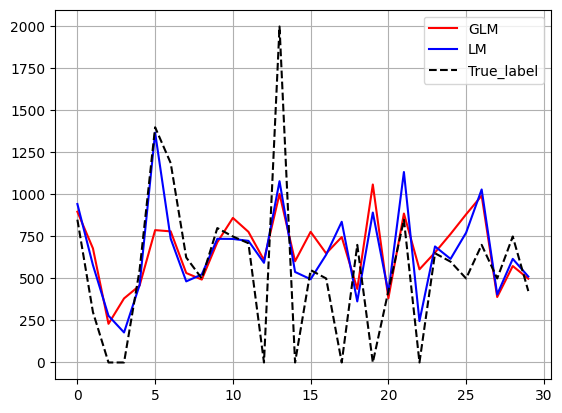

In [380]:
plt.plot(GLM.predict(test_[columns][:30]),color="red",label="GLM")
plt.plot(LinearRegression.predict(test_[columns][:30]),color="blue",label="LM")
plt.plot(test_[label].values[:30],color="black",linestyle="--",label="True_label")
plt.legend()
plt.grid()

In [375]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], *, data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on 

In [332]:
grad_=np.array(mse_list)-np.array(GLM_mse_list)

In [338]:
grad_.mean()/grad_.std()*(99**0.5)

np.float64(3.3434365081619557)

In [340]:
print(st.ttest_1samp(grad_,0))

TtestResult(statistic=np.float64(3.3434365081619557), pvalue=np.float64(0.0011692004047999854), df=np.int64(99))


In [285]:
GLM_mse_mean=np.array(GLM_mse_list).mean()
opt_mse_func=lambda x:st.ttest_1samp(GLM_mse_list,popmean=x).pvalue-0.05
over=opt.root_scalar(opt_mse_func,bracket=[GLM_mse_mean,GLM_mse_mean*1e8])

In [304]:
test_stats=(GLM_mse_mean-over.root)/np.array(GLM_mse_list).std()*(99**0.5)
test_stats

np.float64(-1.9842169515864174)

In [306]:
st.ttest_1samp(GLM_mse_list,0)

TtestResult(statistic=np.float64(1.016763825727068), pvalue=np.float64(0.31174421270003466), df=np.int64(99))

In [307]:
st.t.sf(np.float64(1.016763825727068),df=99)

np.float64(0.15587210635001733)

In [301]:
GLM_mse_mean

np.float64(39884035.15534962)

In [267]:
x_range=np.linspace(-4,4,100)
y_t=st.t.pdf(x_range,df=99)

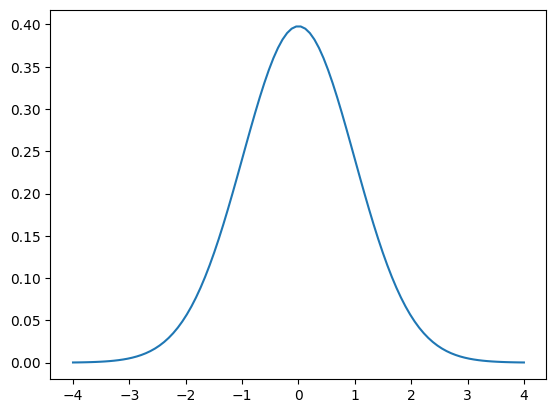

In [268]:
plt.plot(x_range,y_t)